## EXPLORATORY DATA ANALYSIS OF DATA

The goal of this project is to build a recommendation engine to recommend product to the customers based on their previous interaction with the store. This project has two phases
* The candidate generation : This phases generate the n-possible product for the user 
* Reranker : This rrerankers the possible product  and tailors it to the user, reranking the most relevant to the user

## DATASET
This dataset contains 20M users' events from eCommerce website, This file contains behavior data for 5 months (Oct 2019 – Feb 2020) from a medium cosmetics online store.

Each row in the file represents an event. All events are related to products and users. Each event is like many-to-many relation between products and users.



There are different types of events. See below.

### Semantics (or how to read it):

User user_id during session user_session added to shopping cart (property event_type is equal cart) 

product product_id of brand brand of category category_code (category_code) with price price at event_time

File structure
Property	            Description

**event_time**	Time when event happened at (in UTC).

**event_type**	Only one kind of event: purchase.

**product_id**	ID of a product

**category_id**	Product's category ID

**category_code**	Product's category taxonomy (code name) if it was possible to make it. Usually present for meaningful categories and skipped for different kinds of accessories.

**brand** Downcased string of brand name. Can be missed.

**price**	Float price of a product. Present.

**user_id**	Permanent user ID.

**user_session**	Temporary user's session ID. Same for each user's session. Is changed every time user come back to online store from a long pause.


Event types
Events can be:
view - a user viewed a product
cart - a user added a product to shopping cart
remove_from_cart - a user removed a product from shopping cart
purchase - a user purchased a product


Multiple purchases per session
A session can have multiple purchase events. It's ok, because it's a single order.

In [1]:
# import libraries

import os
os.chdir('/home/azureuser/cloudfiles/code/Users/oviemunooboro/Product_recommendation_system/')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from src.cloud_storage.azure_blob_storage import AzureDatastore
from src.utils.commons import read_yaml
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_timestamp,to_date,count_distinct,weekofyear,unix_timestamp, lag, avg, when,col
from pyspark.sql import functions as F
from pyspark.sql.window import Window


In [2]:
# Initialize SparkSession
spark = SparkSession.builder \
    .appName("ProductRecommendationSystem") \
    .getOrCreate()

24/12/07 11:40:30 WARN Utils: Your hostname, oviemunooboro2 resolves to a loopback address: 127.0.0.1; using 10.0.0.4 instead (on interface eth0)
24/12/07 11:40:30 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/07 11:40:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
oct_data_ps = spark.read.csv('/home/azureuser/cloudfiles/code/Users/oviemunooboro/Product_recommendation_system/Artifacts/ingested_data/2019-Oct.csv',header=True,inferSchema=True)
nov_data_ps = spark.read.csv('/home/azureuser/cloudfiles/code/Users/oviemunooboro/Product_recommendation_system/Artifacts/ingested_data/2019-Nov.csv',header=True,inferSchema=True)
dec_data_ps = spark.read.csv('/home/azureuser/cloudfiles/code/Users/oviemunooboro/Product_recommendation_system/Artifacts/ingested_data/2019-Dec.csv',header=True,inferSchema=True)
jan_data_ps = spark.read.csv('/home/azureuser/cloudfiles/code/Users/oviemunooboro/Product_recommendation_system/Artifacts/ingested_data/2020-Jan.csv',header=True,inferSchema=True)
feb_data_ps = spark.read.csv('/home/azureuser/cloudfiles/code/Users/oviemunooboro/Product_recommendation_system/Artifacts/ingested_data/2020-feb.csv',header=True,inferSchema=True)

In [4]:
oct_data_ps.show()

+-------------------+----------------+----------+-------------------+-------------+--------+-----+---------+--------------------+
|         event_time|      event_type|product_id|        category_id|category_code|   brand|price|  user_id|        user_session|
+-------------------+----------------+----------+-------------------+-------------+--------+-----+---------+--------------------+
|2019-10-01 00:00:00|            cart|   5773203|1487580005134238553|         NULL|  runail| 2.62|463240011|26dd6e6e-4dac-477...|
|2019-10-01 00:00:03|            cart|   5773353|1487580005134238553|         NULL|  runail| 2.62|463240011|26dd6e6e-4dac-477...|
|2019-10-01 00:00:07|            cart|   5881589|2151191071051219817|         NULL|  lovely|13.48|429681830|49e8d843-adf3-428...|
|2019-10-01 00:00:07|            cart|   5723490|1487580005134238553|         NULL|  runail| 2.62|463240011|26dd6e6e-4dac-477...|
|2019-10-01 00:00:15|            cart|   5881449|1487580013522845895|         NULL|  lovel

Split the datasets into training , validations and test sets. I will be splitting by months in order to prevent data leakage into validation and test sets. So first three month will be used for training and the last two months will be used for validation and test set repectively

In [5]:
training_data_sp = oct_data_ps.union(nov_data_ps).union(dec_data_ps)
validation_data_sp = jan_data_ps
test_data_sp = feb_data_ps

In [6]:
training_data_sp.show()

+-------------------+----------------+----------+-------------------+-------------+--------+-----+---------+--------------------+
|         event_time|      event_type|product_id|        category_id|category_code|   brand|price|  user_id|        user_session|
+-------------------+----------------+----------+-------------------+-------------+--------+-----+---------+--------------------+
|2019-10-01 00:00:00|            cart|   5773203|1487580005134238553|         NULL|  runail| 2.62|463240011|26dd6e6e-4dac-477...|
|2019-10-01 00:00:03|            cart|   5773353|1487580005134238553|         NULL|  runail| 2.62|463240011|26dd6e6e-4dac-477...|
|2019-10-01 00:00:07|            cart|   5881589|2151191071051219817|         NULL|  lovely|13.48|429681830|49e8d843-adf3-428...|
|2019-10-01 00:00:07|            cart|   5723490|1487580005134238553|         NULL|  runail| 2.62|463240011|26dd6e6e-4dac-477...|
|2019-10-01 00:00:15|            cart|   5881449|1487580013522845895|         NULL|  lovel

## DATA CLEANING

In [7]:
print(training_data_sp.schema)

StructType([StructField('event_time', TimestampType(), True), StructField('event_type', StringType(), True), StructField('product_id', IntegerType(), True), StructField('category_id', LongType(), True), StructField('category_code', StringType(), True), StructField('brand', StringType(), True), StructField('price', DoubleType(), True), StructField('user_id', IntegerType(), True), StructField('user_session', StringType(), True)])


In [8]:
# check for missing values 
# Count missing values for each column
tr_missing_values = {
    col_name: training_data_sp.filter(training_data_sp[col_name].isNull()).count()
    for col_name in training_data_sp.columns
}

va_missing_values = {
    col_name: validation_data_sp.filter(validation_data_sp[col_name].isNull()).count()
    for col_name in validation_data_sp.columns
}

print(f'number of missing values in training data : \n{tr_missing_values}')
print(f'number of missing values in validation data :\n {va_missing_values}')


number of missing values in training data : 
{'event_time': 0, 'event_type': 0, 'product_id': 0, 'category_id': 0, 'category_code': 12069716, 'brand': 5155579, 'price': 0, 'user_id': 0, 'user_session': 2229}
number of missing values in validation data :
 {'event_time': 0, 'event_type': 0, 'product_id': 0, 'category_id': 0, 'category_code': 4190033, 'brand': 1775630, 'price': 0, 'user_id': 0, 'user_session': 1314}


Literally, all the data points in the category_code in both dataframe are missing, then about half of the data point in the brand column are also missing

The `category_code` and `brand` columns contain many missing values, especially in `category_code`, which is missing in a large portion of the dataset. In contrast, the `user_session` column has very few missing values, so we can remove these records without significantly impacting model performance.

To address missing values in `brand`, we will attempt to map `product_id` with `brand` . If a `product_id` already has a known `brand` in other rows, we will use that information to fill in the missing values for the same product_id.

For the `category_code` will drop it, cos i don't see any meaningful information, it is giving to the dataset.

In [9]:
training_data_cache = training_data_sp.cache()
validation_data_cache = validation_data_sp.cache()

In [10]:
# dropping category_code

training_data_cache = training_data_cache.drop('category_code')
validation_data_cache = validation_data_cache.drop('category_code')

In [11]:
training_data_cache.show()

24/12/07 11:44:16 WARN MemoryStore: Not enough space to cache rdd_271_11 in memory! (computed 26.6 MiB so far)================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================>                                                                                                                                                                                                                                                                                                            (9 + 4) / 13]

+-------------------+----------------+----------+-------------------+--------+-----+---------+--------------------+
|         event_time|      event_type|product_id|        category_id|   brand|price|  user_id|        user_session|
+-------------------+----------------+----------+-------------------+--------+-----+---------+--------------------+
|2019-10-01 00:00:00|            cart|   5773203|1487580005134238553|  runail| 2.62|463240011|26dd6e6e-4dac-477...|
|2019-10-01 00:00:03|            cart|   5773353|1487580005134238553|  runail| 2.62|463240011|26dd6e6e-4dac-477...|
|2019-10-01 00:00:07|            cart|   5881589|2151191071051219817|  lovely|13.48|429681830|49e8d843-adf3-428...|
|2019-10-01 00:00:07|            cart|   5723490|1487580005134238553|  runail| 2.62|463240011|26dd6e6e-4dac-477...|
|2019-10-01 00:00:15|            cart|   5881449|1487580013522845895|  lovely| 0.56|429681830|49e8d843-adf3-428...|
|2019-10-01 00:00:16|            cart|   5857269|1487580005134238553|  r

Not much of the missing values in the brand column where filled using the map, so we will replace the Nan with 'UNKNOWN' and then delete the missing values in the user_session column

In [12]:
training_data_cache = training_data_cache.fillna({'brand':'UNKNOWN'})
validation_data_cache = validation_data_cache.fillna({'brand':'UNKNOWN'})

training_data_cache = training_data_cache.dropna(subset=['user_session'])
validation_data_cache = validation_data_cache.dropna(subset=['user_session'])

In [13]:
# check for missing values 
# Count missing values for each column
tr_missing_values = {
    col_name: training_data_cache.filter(training_data_cache[col_name].isNull()).count()
    for col_name in training_data_cache.columns
}

va_missing_values = {
    col_name: validation_data_cache.filter(validation_data_cache[col_name].isNull()).count()
    for col_name in validation_data_cache.columns
}

print(f'number of missing values in training data : \n{tr_missing_values}')
print(f'number of missing values in validation data :\n {va_missing_values}')

24/12/07 11:44:21 WARN MemoryStore: Not enough space to cache rdd_271_11 in memory! (computed 7.0 MiB so far)
24/12/07 11:44:21 WARN MemoryStore: Not enough space to cache rdd_271_9 in memory! (computed 13.4 MiB so far)
24/12/07 11:44:21 WARN MemoryStore: Not enough space to cache rdd_271_11 in memory! (computed 7.0 MiB so far)
24/12/07 11:44:21 WARN MemoryStore: Not enough space to cache rdd_271_9 in memory! (computed 13.4 MiB so far)
24/12/07 11:44:21 WARN MemoryStore: Not enough space to cache rdd_271_9 in memory! (computed 13.4 MiB so far)
24/12/07 11:44:21 WARN MemoryStore: Not enough space to cache rdd_271_11 in memory! (computed 13.4 MiB so far)
24/12/07 11:44:21 WARN MemoryStore: Not enough space to cache rdd_271_11 in memory! (computed 7.0 MiB so far)
24/12/07 11:44:22 WARN MemoryStore: Not enough space to cache rdd_271_9 in memory! (computed 13.4 MiB so far)
24/12/07 11:44:22 WARN MemoryStore: Not enough space to cache rdd_271_11 in memory! (computed 7.0 MiB so far)
24/12/07 

number of missing values in training data : 
{'event_time': 0, 'event_type': 0, 'product_id': 0, 'category_id': 0, 'brand': 0, 'price': 0, 'user_id': 0, 'user_session': 0}
number of missing values in validation data :
 {'event_time': 0, 'event_type': 0, 'product_id': 0, 'category_id': 0, 'brand': 0, 'price': 0, 'user_id': 0, 'user_session': 0}


In [14]:
training_data_cache.show()

+-------------------+----------------+----------+-------------------+--------+-----+---------+--------------------+
|         event_time|      event_type|product_id|        category_id|   brand|price|  user_id|        user_session|
+-------------------+----------------+----------+-------------------+--------+-----+---------+--------------------+
|2019-10-01 00:00:00|            cart|   5773203|1487580005134238553|  runail| 2.62|463240011|26dd6e6e-4dac-477...|
|2019-10-01 00:00:03|            cart|   5773353|1487580005134238553|  runail| 2.62|463240011|26dd6e6e-4dac-477...|
|2019-10-01 00:00:07|            cart|   5881589|2151191071051219817|  lovely|13.48|429681830|49e8d843-adf3-428...|
|2019-10-01 00:00:07|            cart|   5723490|1487580005134238553|  runail| 2.62|463240011|26dd6e6e-4dac-477...|
|2019-10-01 00:00:15|            cart|   5881449|1487580013522845895|  lovely| 0.56|429681830|49e8d843-adf3-428...|
|2019-10-01 00:00:16|            cart|   5857269|1487580005134238553|  r

## EXPLORATORY DATA ANALYSIS

In [15]:
training_data_cache.show()

+-------------------+----------------+----------+-------------------+--------+-----+---------+--------------------+
|         event_time|      event_type|product_id|        category_id|   brand|price|  user_id|        user_session|
+-------------------+----------------+----------+-------------------+--------+-----+---------+--------------------+
|2019-10-01 00:00:00|            cart|   5773203|1487580005134238553|  runail| 2.62|463240011|26dd6e6e-4dac-477...|
|2019-10-01 00:00:03|            cart|   5773353|1487580005134238553|  runail| 2.62|463240011|26dd6e6e-4dac-477...|
|2019-10-01 00:00:07|            cart|   5881589|2151191071051219817|  lovely|13.48|429681830|49e8d843-adf3-428...|
|2019-10-01 00:00:07|            cart|   5723490|1487580005134238553|  runail| 2.62|463240011|26dd6e6e-4dac-477...|
|2019-10-01 00:00:15|            cart|   5881449|1487580013522845895|  lovely| 0.56|429681830|49e8d843-adf3-428...|
|2019-10-01 00:00:16|            cart|   5857269|1487580005134238553|  r

In [16]:
training_data_cache.count()

24/12/07 11:44:44 WARN MemoryStore: Not enough space to cache rdd_271_4 in memory! (computed 44.3 MiB so far)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              (1 + 4) / 13]

12269177

24/12/07 11:44:46 WARN MemoryStore: Not enough space to cache rdd_271_4 in memory! (computed 25.8 MiB so far)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              (0 + 4) / 13]

Text(0.5, 1.0, 'Frequency of event type')

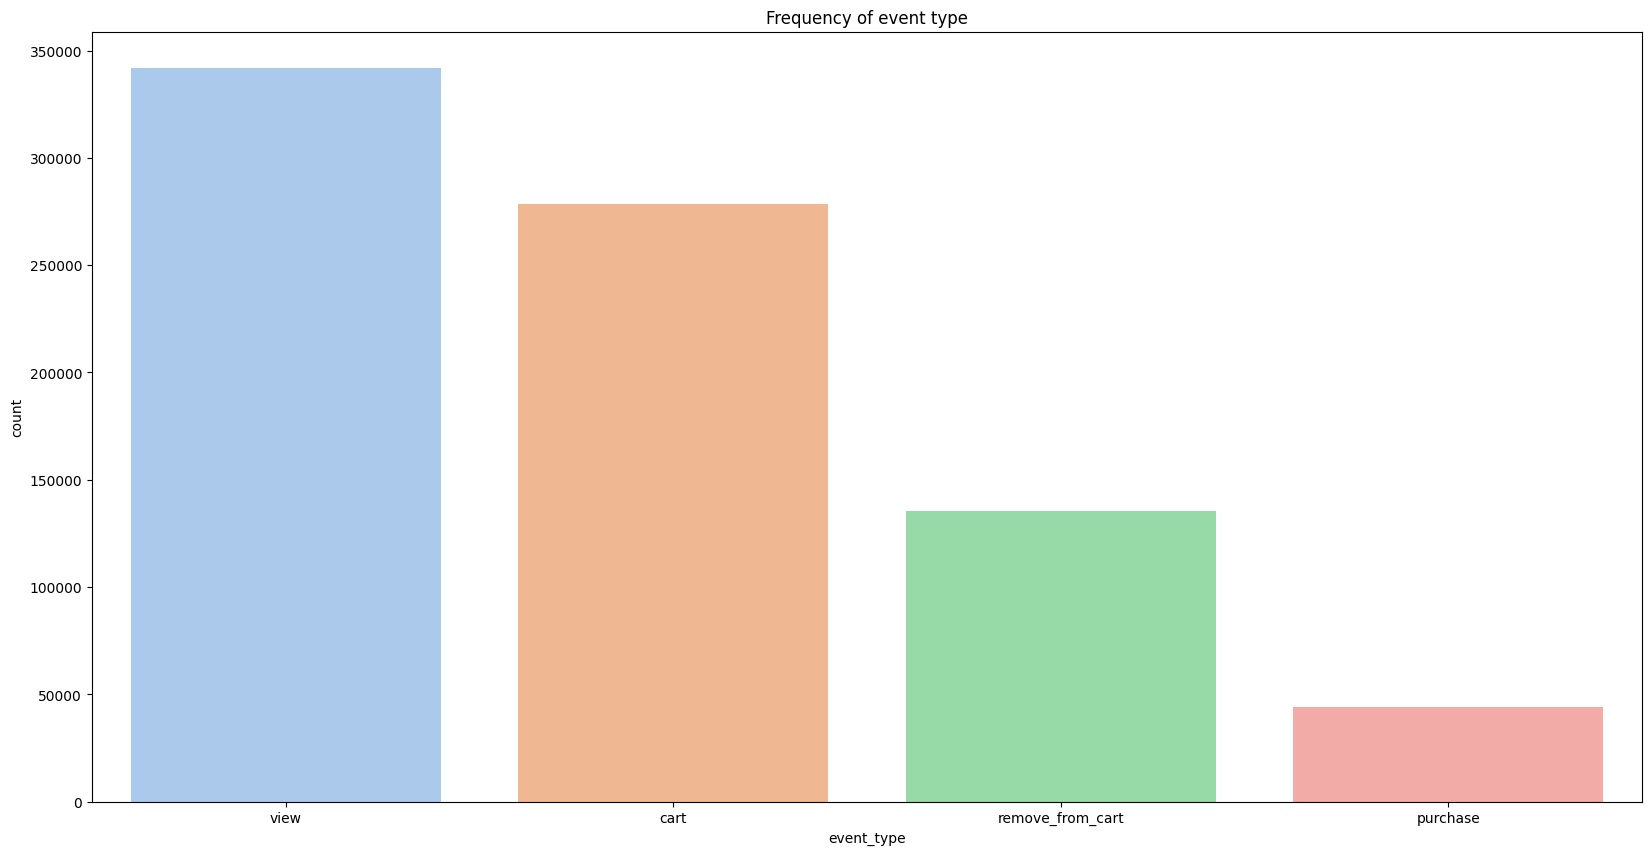

In [17]:
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")


# ditribution of event_type
training_data_pandas = training_data_cache.limit(800000)
training_data_pandas = training_data_pandas.toPandas()

plt.figure(figsize=[20,10])
sns.countplot(data=training_data_pandas,
              x='event_type',order=training_data_pandas['event_type'].value_counts().index,palette='pastel')
plt.title(
    'Frequency of event type'
)

* There are more view event the data compared to the rest, which is understandable as users will be searching more in order to purchase their desired product.
* Add to cart also has a very good percentage as well as the remove from cart category which might signal, lost of interest to buy the product, seen a better deal or difficulty completing puchase.
* Volume of purchase seems to be the least event type while compared to the rest event type.

Text(0.5, 1.0, 'Distibution of price')

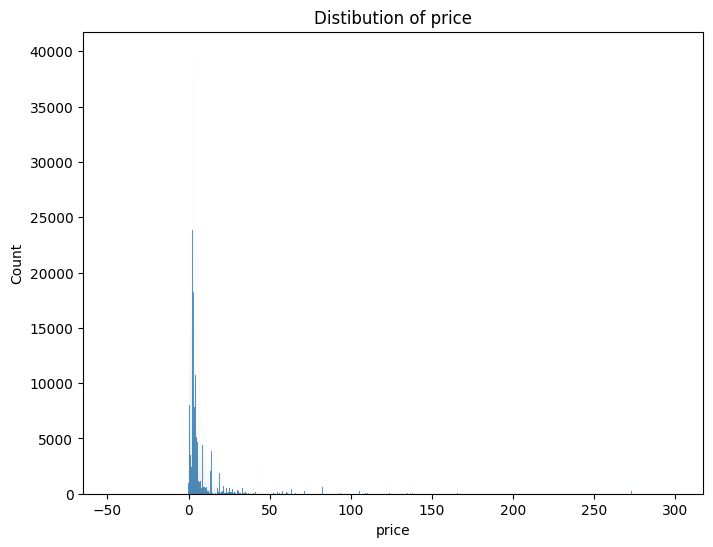

In [18]:
#  distribution of the price



plt.figure(figsize=[8,6])
sns.histplot(
    data=training_data_pandas,x='price'
)
plt.title('Distibution of price')

The price of product in the store are right skewed. Most cosmetics prices were around (which might be a free product on the store) to 20, with some extreme outlliers ranging to over 200

#### previous view before purchase



In [19]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Step 1: Sort the DataFrame
training_data_spark_sorted = training_data_cache.orderBy(['user_id', 'user_session', 'event_time'])

# Step 2: Add the 'session_purchase' column
# We need to check if 'purchase' is in any of the event_type values per group (user_id, user_session)

# Create a window specification to group by 'user_id' and 'user_session'
window_spec = Window.partitionBy('user_id', 'user_session')

# Create a flag column where 'purchase' is checked in each group
training_data_spark_sorted = training_data_spark_sorted.withColumn(
    'session_purchase',
    F.when(F.array_contains(F.collect_list('event_type').over(window_spec), 'purchase'), True).otherwise(False)
)


In [20]:
training_data_spark_sorted.show()

24/12/07 11:44:58 WARN MemoryStore: Not enough space to cache rdd_271_4 in memory! (computed 25.8 MiB so far)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              (0 + 4) / 13]

+-------------------+----------------+----------+-------------------+---------+-----+--------+--------------------+----------------+
|         event_time|      event_type|product_id|        category_id|    brand|price| user_id|        user_session|session_purchase|
+-------------------+----------------+----------+-------------------+---------+-----+--------+--------------------+----------------+
|2019-11-04 15:28:57|            view|      5240|1487580009202712597|   runail| 4.05| 1120748|d0484d94-7ac1-44e...|           false|
|2019-11-08 18:01:24|            view|   5677479|1487580009336930331|  UNKNOWN| 20.0| 9478445|5a9772de-8768-44a...|           false|
|2019-11-25 04:50:11|            view|   5811668|1487580005427839846|    irisk| 2.48| 9794320|0906f5b2-836d-448...|           false|
|2019-11-26 18:19:18|            view|   5809910|1602943681873052386|  grattol| 5.24|10280338|911b977b-096b-444...|           false|
|2019-11-26 18:23:46|            view|   5870648|1487580006451250072|

In [21]:

# Step 1: Filter for sessions with purchases
purchase_sessions = training_data_spark_sorted.filter(training_data_spark_sorted['session_purchase'] == True)

# Step 2: Create a flag column for 'view' event type
purchase_sessions = purchase_sessions.withColumn(
    'is_view',
    F.when(purchase_sessions['event_type'] == 'view', 1).otherwise(0)
)

# Step 3: Create a window specification to group by 'user_id' and 'user_session' and order by 'event_time'
window_spec = Window.partitionBy('user_id', 'user_session').orderBy('event_time')

# Step 4: Calculate cumulative sum of 'view' events for each session before the purchase
purchase_sessions = purchase_sessions.withColumn(
    'views_before_purchase',
    F.sum('is_view').over(window_spec)
)

# Step 5: Filter out only the rows where the 'event_type' is 'purchase' (if needed)
purchase_sessions = purchase_sessions.filter(purchase_sessions['event_type'] == 'purchase')

# Step 6: Select the relevant columns for display
purchase_sessions = purchase_sessions.select('user_id', 'user_session', 'views_before_purchase')

# Show the result
purchase_sessions.show()


24/12/07 11:45:22 WARN MemoryStore: Not enough space to cache rdd_271_5 in memory! (computed 26.2 MiB so far)====================================================>                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         (2 + 4) / 13]

+--------+--------------------+---------------------+
| user_id|        user_session|views_before_purchase|
+--------+--------------------+---------------------+
|10079204|f873d16b-4efa-4e9...|                    0|
|10079204|f873d16b-4efa-4e9...|                    0|
|12055855|98b129c4-2ab1-4e8...|                   10|
|12055855|98b129c4-2ab1-4e8...|                   10|
|12055855|98b129c4-2ab1-4e8...|                   10|
|12055855|98b129c4-2ab1-4e8...|                   10|
|25392526|2554bc2a-6b13-2be...|                    0|
|25392526|2554bc2a-6b13-2be...|                    0|
|25392526|2554bc2a-6b13-2be...|                    0|
|33535391|7cc0286a-90a2-421...|                   15|
|33535391|7cc0286a-90a2-421...|                   15|
|33535391|7cc0286a-90a2-421...|                   15|
|33535391|7cc0286a-90a2-421...|                   15|
|33535391|7cc0286a-90a2-421...|                   15|
|33535391|7cc0286a-90a2-421...|                   15|
|33535391|7cc0286a-90a2-421.

24/12/07 11:45:47 WARN MemoryStore: Not enough space to cache rdd_271_6 in memory! (computed 13.2 MiB so far)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              (0 + 4) / 13]

Text(0.5, 1.0, 'Number of view before purchase in a session')

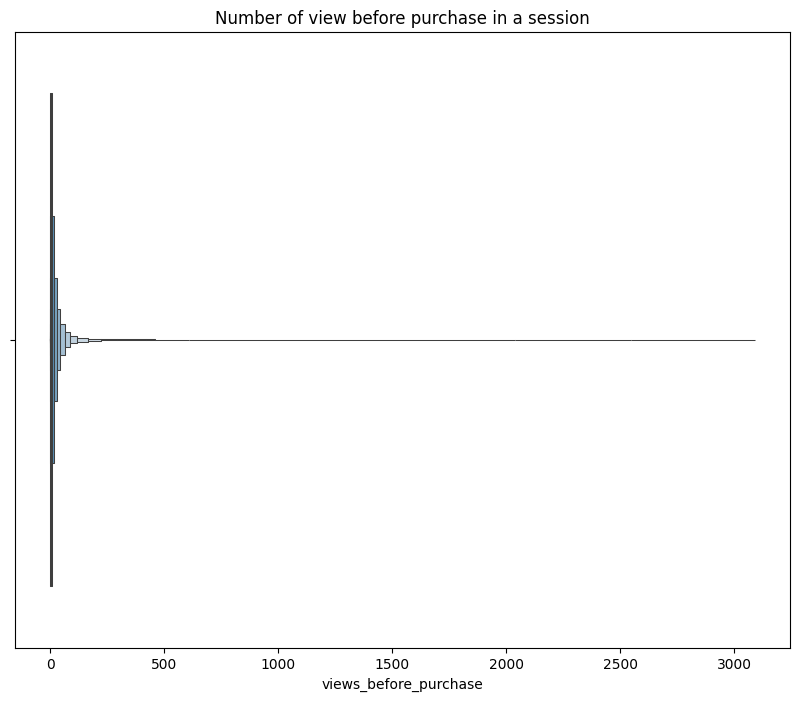

In [22]:
purchase_sessions_pandas = purchase_sessions.toPandas()



plt.figure(figsize=[10,8])
sns.boxenplot(
    data= purchase_sessions_pandas,x='views_before_purchase'
)
plt.title('Number of view before purchase in a session')


In [23]:
purchase_sessions_pandas.describe()

,user_id,views_before_purchase
count,7.812170e+05,781217.000000
mean,5.004755e+08,8.436120
std,9.033102e+07,24.333273
min,9.794320e+06,0.000000
25%,4.609140e+08,0.000000
50%,5.373387e+08,3.000000
75%,5.641758e+08,9.000000
max,5.954135e+08,3089.000000


### User daily visit frequency

In [24]:

# Extract the date (without time) from event_time
training_data_cache = training_data_cache.withColumn("date", to_date("event_time"))

# Count distinct sessions per user per day
daily_visit_frequency = training_data_cache.groupBy("user_id", "date").agg(count_distinct("user_session").alias("distinct_sessions"))

# Now, count how many distinct days each user visited
user_daily_visit_frequency = daily_visit_frequency.groupBy("user_id").agg(count_distinct("date").alias("daily_visit_frequency"))

# Show the result
user_daily_visit_frequency.show()

24/12/07 11:46:26 WARN MemoryStore: Not enough space to cache rdd_271_4 in memory! (computed 25.8 MiB so far)===============================================================================================================================>                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              (3 + 4) / 13]

+---------+---------------------+
|  user_id|daily_visit_frequency|
+---------+---------------------+
|555753193|                    1|
|552330911|                    1|
|557587262|                    1|
|557668807|                    1|
|550265856|                    3|
|557489579|                    2|
|557548447|                    1|
|454451260|                    1|
|555554581|                    1|
|554624916|                    4|
|553119781|                    6|
|544949354|                    5|
|500285869|                    1|
|557417521|                    1|
|539253386|                   25|
|424552330|                    1|
|555035499|                    2|
|520415590|                    1|
|556263378|                    1|
|548166593|                    3|
+---------+---------------------+
only showing top 20 rows



24/12/07 11:46:30 WARN MemoryStore: Not enough space to cache rdd_271_6 in memory! (computed 13.2 MiB so far)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              (0 + 4) / 13]

Text(0.5, 1.0, 'user daily visit frequency')

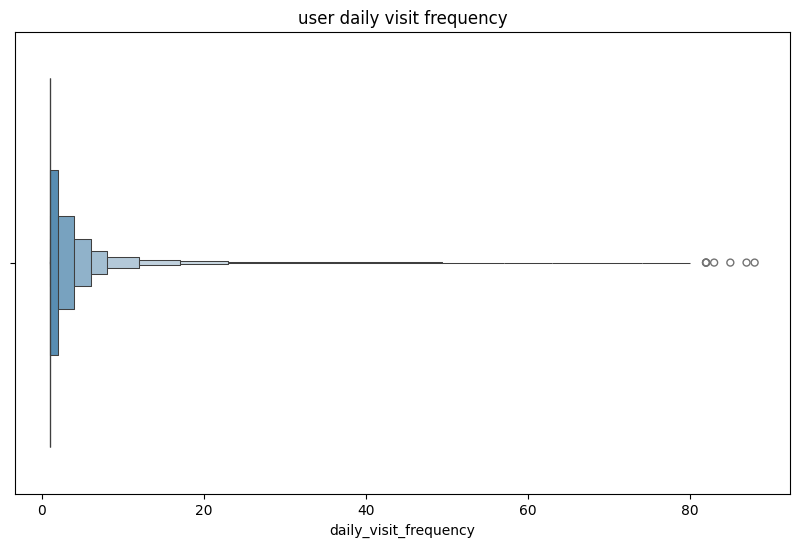

In [25]:
user_visit_freq = user_daily_visit_frequency.toPandas()

plt.figure(figsize=[10,6])
sns.boxenplot(
    data=user_visit_freq,x='daily_visit_frequency'
)

plt.title('user daily visit frequency')

In [26]:
# Extract the week number from event_time
training_data_cache  = training_data_cache .withColumn("week", weekofyear("event_time"))

# Count distinct sessions per user per week
weekly_visit_frequency = training_data_cache .groupBy("user_id", "week").agg(count_distinct("user_session").alias("distinct_sessions"))

# Now, count how many distinct weeks each user visited
user_weekly_visit_frequency = weekly_visit_frequency.groupBy("user_id").agg(count_distinct("week").alias("weekly_visit_frequency"))

# Show the result
user_weekly_visit_frequency.show()

24/12/07 11:46:36 WARN MemoryStore: Not enough space to cache rdd_271_6 in memory! (computed 13.2 MiB so far)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              (1 + 4) / 13]

+---------+----------------------+
|  user_id|weekly_visit_frequency|
+---------+----------------------+
|557343959|                     1|
|533907277|                     6|
|557655984|                     1|
|507738194|                     4|
|555964526|                     1|
|556179936|                     1|
|449201906|                     8|
|480509688|                     2|
|557540131|                     1|
|555729758|                     1|
|557299556|                     1|
|557495235|                     1|
|319326572|                     1|
|448127053|                     9|
|557329496|                     1|
|557450761|                     1|
|546404106|                    11|
|557483980|                     1|
|556975101|                     3|
|474928009|                     4|
+---------+----------------------+
only showing top 20 rows



24/12/07 11:46:40 WARN MemoryStore: Not enough space to cache rdd_271_6 in memory! (computed 6.7 MiB so far)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               (0 + 4) / 13]

Text(0.5, 1.0, 'user daily visit frequency')

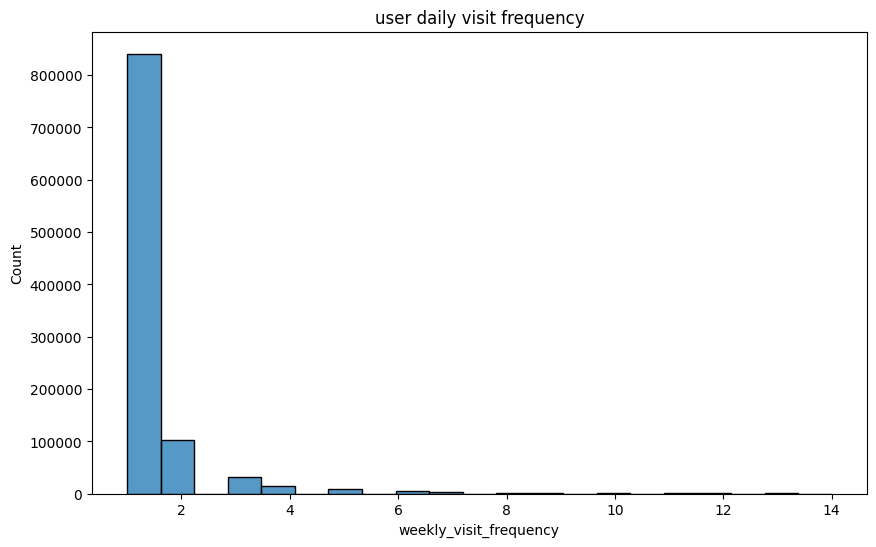

In [27]:
user_weekly_visit_frequency_pandas= user_weekly_visit_frequency.toPandas()

plt.figure(figsize=[10,6])
sns.histplot(
    data=user_weekly_visit_frequency_pandas,x='weekly_visit_frequency'
)

plt.title('user daily visit frequency')

## Average session length

In [ ]:
# define window spec by partion of user and session , orderby event time

window_spec = Window.partitionBy(['user_id','user_session']).orderBy('event_time')

training_data_cache = training_data_cache.withColumn(
    'time_diff', unix_timestamp(col('event_time')) - unix_timestamp(lag('event_time').over(window_spec))
)

training_data_cache = training_data_cache.fillna({'time_diff':0})
print('=========================================================')

# Calculate the total session length by summing time_diff per session
session_length = training_data_cache.groupBy('user_id','user_session').agg(sum(col('time_diff').cast("float")).alias('session_length'))

# Calculate the average session length per user
average_session_length = session_length.groupBy('user_id').agg(avg('session_length').alias('average_session_length'))

average_session_length.show()


TypeError: unsupported operand type(s) for +: 'int' and 'str'

In [63]:


training_data_cache.printSchema()

root
 |-- event_time: timestamp (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- category_id: long (nullable = true)
 |-- brand: string (nullable = false)
 |-- price: double (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- user_session: string (nullable = true)
 |-- date: date (nullable = true)
 |-- week: integer (nullable = true)
 |-- time_diff: float (nullable = false)

